In [4]:
import sys
import os

import numpy as np
import tensorflow as tf
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._tree import TREE_LEAF, TREE_UNDEFINED
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
from functools import partial
import pickle

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import load_data, max_node_count, refine_prune_index, is_leaf
from vae_dataset_generator import initial_population
from tree_encoder import JakowskiEncoder
from vae import CVAE

In [5]:
def generate_random_trees(X, y, max_depth, n_trees=1000):
    clfs = []
    depths = []
    for i in range(n_trees):
        clf = DecisionTreeClassifier(max_depth=random.randint(3, max_depth), 
                                     random_state=random.randint(0, 2**32-1))
        clf = clf.fit(X, y)
        clfs.append(clf)
        depths.append(clf.tree_.max_depth)
        
    return clfs, depths

def return_linear_representation(clf, encoder, depths):
    max_depth = max(depths)
    return encoder.encode(clf=clf, depth=max_depth)

def generate_linear_trees(random_trees, depths, encoder):
    
    linear_trees = list(map(partial(return_linear_representation, 
                               encoder=encoder, depths=depths), random_trees))
    
    max_dim = max_node_count(max(depths))
    if (max_dim % 2) != 0:
        max_dim = max_dim + 1
        
    linear_trees = [encoder.pad(vector=tree, dim=max_dim) 
                    for tree in linear_trees if tree.shape[1]<max_dim]
    
    linear_trees = np.array(linear_trees, dtype=object).astype('float32')
    
    return linear_trees

def generate_latent_trees(linear_trees, model, scalers, n_trees=1000):
    
    trees = linear_trees.copy()
    trees = np.transpose(trees, (0, 2, 1))    
    
    for i in range(trees.shape[2]):
        trees[:, :, i] = scalers[i].fit_transform(trees[:, :, i]) 

    trees = trees.astype('float32')
    
    z_mean, z_logvar = tf.split(model.encoder(trees), num_or_size_splits=2, axis=1)
    latent_trees = model.reparameterize(z_mean, z_logvar)
    
    return latent_trees.numpy()

def from_latent_to_pca(latent_trees):
    pca = PCA(n_components=2)
    pca.fit(latent_trees)
    pca_trees = pca.transform(latent_trees)
    
    return pca_trees

def from_latent_to_tsne(latent_trees):
    tsne_tree = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(latent_trees)
    
    return tsne_tree

In [6]:
def vae_fit(X, y, depth):

    train_size = 10000 
    test_size = 5000
    batch_size = 64
    epochs = 100 
    trees_learning_function = "DT"

    # VAE dataset
    result_init = initial_population(
                                    X=X, 
                                    y=y, 
                                    max_depth=depth,
                                    train_size=train_size, 
                                    test_size=test_size, 
                                    encoder=encoder,
                                    mode = trees_learning_function,
                                    same_depth=False
                                )

    vae_train = np.transpose(result_init[0], (0, 2, 1))
    vae_test = np.transpose(result_init[1], (0, 2, 1))

    # Scaling 
    scalers = {}
    for i in range(vae_train.shape[2]):
        scalers[i] = MinMaxScaler()
        vae_train[:, :, i] = scalers[i].fit_transform(vae_train[:, :, i]) 

    for i in range(vae_test.shape[2]):
        vae_test[:, :, i] = scalers[i].transform(vae_test[:, :, i]) 

    vae_train = vae_train.astype('float32')
    vae_test = vae_test.astype('float32')

    train_dataset = (tf.data.Dataset.from_tensor_slices(vae_train)
                     .shuffle(train_size).batch(batch_size))
    test_dataset = (tf.data.Dataset.from_tensor_slices(vae_test)
                    .shuffle(test_size).batch(batch_size))

    # Model
    model = CVAE(input_shape=(vae_train.shape[1], vae_train.shape[2])) 
    model.fit(epochs=epochs, train_dataset=train_dataset, test_dataset=test_dataset)
    
    return model, scalers

In [7]:
def prune_subtree(inner_tree, index):
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_subtree(inner_tree, inner_tree.children_left[index])
        
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_subtree(inner_tree, inner_tree.children_right[index])
        
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and 
        is_leaf(inner_tree, inner_tree.children_right[index])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        inner_tree.threshold[index] = TREE_UNDEFINED
        inner_tree.feature[index] = TREE_UNDEFINED

def prune_index(inner_tree, depth, current_depth=0, index=0):
    if (depth - current_depth) == 2:
        if not is_leaf(inner_tree, index):
            prune_subtree(inner_tree, index)
    else:
        if not is_leaf(inner_tree, index):
            prune_index(inner_tree, depth, current_depth+1, 
                        inner_tree.children_left[index])
            prune_index(inner_tree, depth, current_depth+1, 
                        inner_tree.children_right[index])
            
def prune_tree(clf, depth):
    prune_index(clf.tree_, depth)
    refine_prune_index(clf)

In [8]:
n_trees = 1000

<h2> Training VAE </h2>

<p> iris depth 4 </p>
<p> pima depth 5 </p>
<p> drybean 7 </p>
<p> car 8 </p>

In [49]:
dataset = "car"
max_depth = 8

# Load data
X_train, X_val, X_test, y_train, y_val, y_test = load_data(dataset)

n_features_in = X_train.shape[1]
n_classes = len(np.unique(y_train))

# Linear encoding
encoder = JakowskiEncoder(n_features=n_features_in, n_classes=n_classes)

Epoch: 29, Test set ELBO: -311.6123046875, time elapse for current epoch: 3.46238374710083


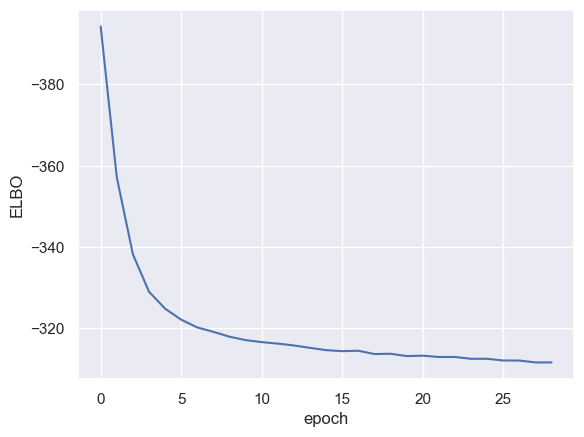

In [50]:
model, scalers = vae_fit(X_train, y_train, depth=max_depth)
model.plot_loss()

<h2> Random trees </h2>

In [51]:
random_trees, depths = generate_random_trees(X_train, y_train, max_depth)

linear_trees = generate_linear_trees(random_trees, depths, encoder)

latent_trees = generate_latent_trees(linear_trees, model, scalers)
latent_dim = latent_trees.shape[1]

pca_trees = from_latent_to_pca(latent_trees)

tsne_trees = from_latent_to_tsne(latent_trees)

In [56]:
# Save "alberi_encodati"

path = ""

file_name_1 = path + "{}/alberi_encodati.txt".format(dataset)
file = open(file_name_1, "w")

string = "id"
for i in range(latent_dim):
    string = string + "l{},".format(i)    
string = string + "pca0,pca1,tsne0,tsne1\n"

file.write(string)
file.close()

file_name_2 = path + "{}/tree2vec.txt".format(dataset)
file = open(file_name_2, "w")
file.close()

for i in range(0, n_trees):
    
    # Dump the trained decision tree classifier with Pickle
    decision_tree_pkl_filename = path + "{}/trees/tree_{}.pkl".format(dataset, i)
    decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
    pickle.dump(random_trees[i], decision_tree_model_pkl)
    decision_tree_model_pkl.close()
    
    file = open(file_name_2, "a")
    string = "Tree: " + str(i) + "\n" + str(linear_trees[i]) + "\n\n"
    file.write(string)
    file.close()
    
    string = str(i)
    
    for j in range(0, latent_dim):
        string = string + "," + str(latent_trees[i][j])
        
    for j in range(0, 2):
        string = string + "," + str(pca_trees[i][j])
        
    for j in range(0, 2):
        string = string + "," + str(tsne_trees[i][j])
        
    string = string + "\n"
        
    file = open(file_name_1, "a")
    file.write(string)
    file.close()

[Text(0.5125, 0.9166666666666666, 'X[3] <= 0.5\ngini = 0.47\nsamples = 1382\nvalue = [312, 59, 953, 58]'),
 Text(0.4625, 0.75, 'gini = 0.0\nsamples = 442\nvalue = [0, 0, 442, 0]'),
 Text(0.5625, 0.75, 'X[5] <= 0.5\ngini = 0.587\nsamples = 940\nvalue = [312, 59, 511, 58]'),
 Text(0.375, 0.5833333333333334, 'X[1] <= 2.5\ngini = 0.639\nsamples = 320\nvalue = [167, 23, 72, 58]'),
 Text(0.2, 0.4166666666666667, 'X[0] <= 0.5\ngini = 0.622\nsamples = 244\nvalue = [133, 23, 30, 58]'),
 Text(0.1, 0.25, 'X[2] <= 0.5\ngini = 0.068\nsamples = 57\nvalue = [55, 0, 2, 0]'),
 Text(0.05, 0.08333333333333333, 'gini = 0.245\nsamples = 14\nvalue = [12, 0, 2, 0]'),
 Text(0.15, 0.08333333333333333, 'gini = 0.0\nsamples = 43\nvalue = [43, 0, 0, 0]'),
 Text(0.3, 0.25, 'X[0] <= 2.5\ngini = 0.692\nsamples = 187\nvalue = [78, 23, 28, 58]'),
 Text(0.25, 0.08333333333333333, 'gini = 0.65\nsamples = 122\nvalue = [36, 23, 5, 58]'),
 Text(0.35, 0.08333333333333333, 'gini = 0.457\nsamples = 65\nvalue = [42, 0, 23, 0]'

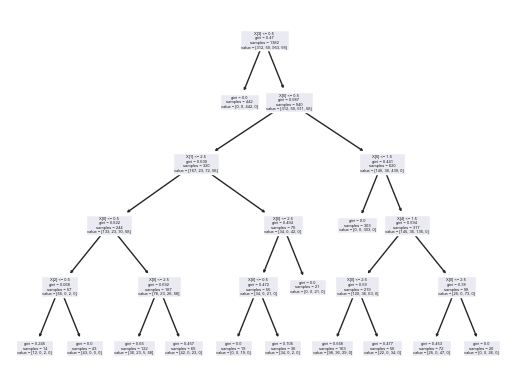

In [57]:
tree.plot_tree(random_trees[0])

<h2> Pruning </h2>

In [58]:
for i in range(0, n_trees):
    prune_tree(clf=random_trees[i], depth=depths[i])

In [59]:
new_depths = []

for i in range(0, n_trees):
    depth = random_trees[i].tree_.max_depth
    new_depths.append(depth)

In [60]:
for i in range(0, n_trees):
    print("{} -> {}".format(depths[i], new_depths[i]))

5 -> 3
8 -> 6
8 -> 6
5 -> 3
4 -> 2
5 -> 3
8 -> 6
6 -> 4
7 -> 5
7 -> 5
8 -> 6
8 -> 6
8 -> 6
4 -> 2
3 -> 1
5 -> 3
3 -> 1
7 -> 5
3 -> 1
3 -> 1
5 -> 3
7 -> 5
4 -> 2
3 -> 1
5 -> 3
6 -> 4
5 -> 3
7 -> 5
3 -> 1
5 -> 3
3 -> 1
7 -> 5
6 -> 4
6 -> 4
3 -> 1
8 -> 6
8 -> 6
3 -> 1
4 -> 2
7 -> 5
7 -> 5
8 -> 6
7 -> 5
5 -> 3
5 -> 3
3 -> 1
6 -> 4
3 -> 1
8 -> 6
5 -> 3
3 -> 1
5 -> 3
3 -> 1
7 -> 5
7 -> 5
4 -> 2
6 -> 4
6 -> 4
7 -> 5
5 -> 3
4 -> 2
7 -> 5
4 -> 2
4 -> 2
4 -> 2
5 -> 3
6 -> 4
5 -> 3
8 -> 6
3 -> 1
5 -> 3
8 -> 6
5 -> 3
5 -> 3
5 -> 3
6 -> 4
4 -> 2
4 -> 2
5 -> 3
8 -> 6
4 -> 2
8 -> 6
5 -> 3
5 -> 3
8 -> 6
5 -> 3
4 -> 2
4 -> 2
4 -> 2
6 -> 4
5 -> 3
6 -> 4
4 -> 2
4 -> 2
6 -> 4
6 -> 4
4 -> 2
7 -> 5
3 -> 1
6 -> 4
6 -> 4
8 -> 6
4 -> 2
4 -> 2
7 -> 5
7 -> 5
3 -> 1
3 -> 1
4 -> 2
5 -> 3
7 -> 5
3 -> 1
7 -> 5
6 -> 4
8 -> 6
8 -> 6
3 -> 1
4 -> 2
6 -> 4
3 -> 1
4 -> 2
8 -> 6
6 -> 4
8 -> 6
4 -> 2
7 -> 5
8 -> 6
5 -> 3
3 -> 1
8 -> 6
5 -> 3
8 -> 6
3 -> 1
4 -> 2
7 -> 5
6 -> 4
5 -> 3
3 -> 1
5 -> 3
5 -> 3
4 -> 2
5 -> 3
6 -> 4

[Text(0.375, 0.875, 'X[3] <= 0.5\ngini = 0.47\nsamples = 1382\nvalue = [312, 59, 953, 58]'),
 Text(0.25, 0.625, 'gini = 0.0\nsamples = 442\nvalue = [0, 0, 442, 0]'),
 Text(0.5, 0.625, 'X[5] <= 0.5\ngini = 0.587\nsamples = 940\nvalue = [312, 59, 511, 58]'),
 Text(0.25, 0.375, 'X[1] <= 2.5\ngini = 0.639\nsamples = 320\nvalue = [167, 23, 72, 58]'),
 Text(0.125, 0.125, 'gini = 0.622\nsamples = 244\nvalue = [133, 23, 30, 58]'),
 Text(0.375, 0.125, 'gini = 0.494\nsamples = 76\nvalue = [34, 0, 42, 0]'),
 Text(0.75, 0.375, 'X[5] <= 1.5\ngini = 0.441\nsamples = 620\nvalue = [145, 36, 439, 0]'),
 Text(0.625, 0.125, 'gini = 0.0\nsamples = 303\nvalue = [0, 0, 303, 0]'),
 Text(0.875, 0.125, 'gini = 0.594\nsamples = 317\nvalue = [145, 36, 136, 0]')]

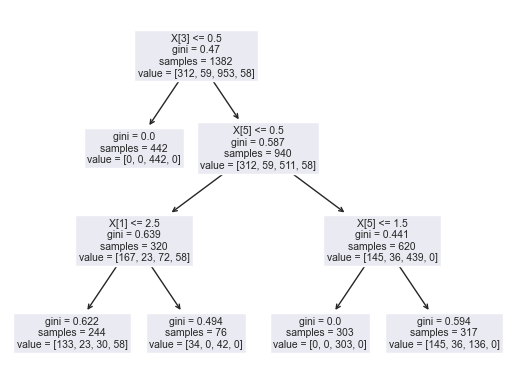

In [61]:
tree.plot_tree(random_trees[0])

In [62]:
linear_trees = generate_linear_trees(random_trees, depths, encoder)

latent_trees = generate_latent_trees(linear_trees, model, scalers)
latent_dim = latent_trees.shape[1]

pca_trees = from_latent_to_pca(latent_trees)

tsne_trees = from_latent_to_tsne(latent_trees)

(1000, 2, 512)

In [67]:
# Save "alberi_encodati_prunati"

file_name_1 = path + "{}/alberi_encodati_prunati.txt".format(dataset)
file = open(file_name_1, "w")

string = "id"
for i in range(latent_dim):
    string = string + "l{},".format(i)    
string = string + "pca0,pca1,tsne0,tsne1\n"

file.write(string)
file.close()

file_name_2 = path + "{}/tree2vec_prunati.txt".format(dataset)
file = open(file_name_2, "w")
file.close()

for i in range(0, n_trees):
    
    # Dump the trained decision tree classifier with Pickle
    decision_tree_pkl_filename = path + "{}/trees_prunati/tree_{}.pkl".format(dataset, i)
    decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
    pickle.dump(random_trees[i], decision_tree_model_pkl)
    decision_tree_model_pkl.close()
    
    file = open(file_name_2, "a")
    string = "Tree: " + str(i) + "\n" + str(linear_trees[i]) + "\n\n"
    file.write(string)
    file.close()
    
    string = str(i)
    
    for j in range(0, latent_dim):
        string = string + "," + str(latent_trees[i][j])
        
    for j in range(0, 2):
        string = string + "," + str(pca_trees[i][j])
        
    for j in range(0, 2):
        string = string + "," + str(tsne_trees[i][j])
        
    string = string + "\n"
        
    file = open(file_name_1, "a")
    file.write(string)
    file.close()